In [ ]:
pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     / 665.5 MB 39 kB/s
     |████████████████████████████████| 463 kB 5.2 MB/s 
     |████████████████████████████████| 1.3 MB 31.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220527125636
    Uninstalling tensorflow-2.8.2+zzzcolab20220527125636:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220527125636


In [ ]:
# pip install tensorflow==2.4.1

In [ ]:
pip install tensorflow-quantum==0.6.0 --use-deprecated=legacy-resolver

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# pip install tensorflow-quantum==0.2.0

In [ ]:
# pip install quple

In [ ]:
import numpy as np 
import sympy as sp
import pandas as pd
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
from cirq.contrib.svg import SVGCircuit
from tensorflow_quantum.python.layers.circuit_construction import elementary
# from quple import ParameterisedCircuit
# import quple

%matplotlib inline
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/cirq/ops/gateset.py:377: UserWarning: v0.14.1 is the last release `cirq.GlobalPhaseGate` is included by default. If you were relying on this behavior, you can include a `cirq.GlobalPhaseGate` in your `*gates`. If not, then you can ignore this warning. It will be removed in v0.16
  'v0.14.1 is the last release `cirq.GlobalPhaseGate` is included by default. If'


In [ ]:
# print(quple._version)

In [ ]:
from google.colab import files
upload_file = files.upload()

Saving QIS_EXAM_200Events.npz to QIS_EXAM_200Events (2).npz


In [ ]:
data = np.load('./QIS_EXAM_200Events.npz',allow_pickle = True)
X_train = data['training_input'].item()
X_test = data['test_input'].item()
# print(X_train['0'])
X_train_0 = X_train['0']
X_test_0 = X_test['0']
X_train_1 = X_train['1']
X_test_1 = X_test['1']


X_train = np.concatenate((X_train_0,X_train_1),axis=0)
X_test = np.concatenate((X_test_0,X_test_1),axis=0)

y_train = np.zeros((len(X_train),1))
y_test = np.zeros((len(X_test),1))
y_train[len(X_train_0):] = 1
y_test[len(X_test_0):] = 1
# print([d.T for d in [X_train_1, X_train_0] ])

print(X_train_0[0].shape)

(5,)


In [ ]:
def make_plots(data, labels, binning=20, columns=3):
    X = [d.T for d in data]
    fig=plt.figure(figsize=(20, 10))
    rows =  1 + (X[0].shape[0] // columns)
    bins = np.histogram(np.hstack(tuple(X)), bins=binning)[1]
    plt.subplots_adjust(hspace=0.3)
    for i in range(X[0].shape[0]):
        ax = fig.add_subplot(rows, columns, i+1)
        ax.set_title('Variable {}'.format(i+1), fontsize=15)
        for j, x in enumerate(X):
            ax.hist(x[i], bins=bins, alpha=.5, label=labels[j])
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.2), ncol=len(data), fontsize=10)
    plt.show()

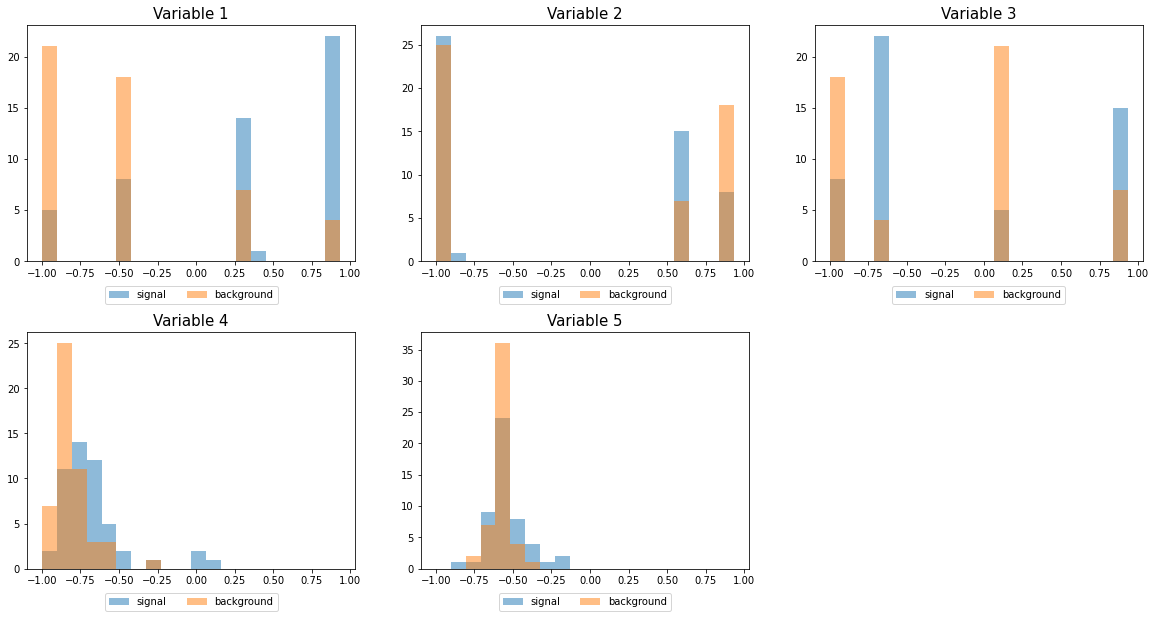

In [ ]:
make_plots([X_train_1, X_train_0], ['signal', 'background'])

In [ ]:
def one_qubit_unitary(qubits,symbols) -> cirq.Circuit :
  circuit = cirq.Circuit()
  # num_qubits = len(qubits)
  # k=0
  # for i in range(num_qubits):
  #   circuit.append(cirq.rx(symbols[k])(qubits[i]))
  #   k+=1
  # for i in range(num_qubits):
  #   circuit.append(cirq.ry(symbols[k])(qubits[i]))
  #   k+=1
  # for i in range(num_qubits):
  #   circuit.append(cirq.rz(symbols[k])(qubits[i]))
  #   k+=1
  circuit.append(cirq.rx(symbols[0])(qubits))
  circuit.append(cirq.ry(symbols[1])(qubits))
  circuit.append(cirq.rz(symbols[2])(qubits))
  return circuit

In [ ]:
def two_qubit_unitary(qubits,symbols):
  circuit = cirq.Circuit()
  num_qubits = len(qubits)
  k=0
  for i in range(1,num_qubits,2):
    circuit.append(cirq.CNOT(qubits[i-1],qubits[i]))
    circuit.append(cirq.rz(symbols[k])(qubits[i]))
    circuit.append(cirq.CNOT(qubits[i-1],qubits[i]))
    k+=1
  
  return circuit

In [ ]:
def entanglement_unitary(qubits,num_qubits):
  circuit = cirq.Circuit()
  for i in range(num_qubits):
    if i<num_qubits-1:
      circuit += cirq.CZ(qubits[i],qubits[i+1])
  if num_qubits!=2 : 
    circuit += cirq.CZ(qubits[num_qubits-1],qubits[0])
  return circuit

In [ ]:
def generator_drc_circuit(qubits,features_size,use_entanglement=False, layers=1):
  circuit = cirq.Circuit()
  num_qubits = len(qubits)
  if(features_size % 3 != 0):
    padding = (3-(features_size % 3)) % 3
  else:
    padding = 0

  bias_symbols = sp.symbols('theta_:'+str((features_size + padding)*layers*num_qubits)) 
  bias_symbols = np.asarray(bias_symbols).reshape(layers,num_qubits,features_size+padding) 
  features_symbols = sp.symbols('x_:'+str((features_size + padding)*layers*num_qubits))
  features_symbols = np.asarray(features_symbols).reshape(layers,num_qubits,features_size+padding)
  for layer in range(layers):
    for gate in range(int(np.ceil(features_size/3))):
      circuit += [one_qubit_unitary(q, features_symbols[layer,i,gate*3:(gate+1)*3]) for i,q in enumerate(qubits)]
      circuit += [one_qubit_unitary(q, bias_symbols[layer,i,gate*3:(gate+1)*3]) for i,q in enumerate(qubits)]
    
    if num_qubits>1 and (layer != layers-1 or layers == 1) and use_entanglement :
      circuit += entanglement_unitary(qubits,num_qubits)
  
  return circuit

In [ ]:
SVGCircuit(generator_drc_circuit(cirq.GridQubit.rect(1,2),5,use_entanglement = True, layers=3))
#print(generator_circuit(cirq.GridQubit.rect(1,2),5,use_entanglement = True, layers=2))

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


In [ ]:
def discriminator_drc_circuit(qubits,features_size,use_entanglement=False, layers=1):
  circuit = cirq.Circuit()
  num_qubits = len(qubits)
  if(features_size % 3 != 0):
    padding = (3-(features_size % 3)) % 3
  else:
    padding = 0

  bias_symbols = sp.symbols('theta_:'+str((features_size + padding)*layers*num_qubits)) 
  bias_symbols = np.asarray(bias_symbols).reshape(layers,num_qubits,features_size+padding) 
  features_symbols = sp.symbols('x_:'+str((features_size + padding)*layers*num_qubits))
  features_symbols = np.asarray(features_symbols).reshape(layers,num_qubits,features_size+padding)
  for layer in range(layers):
    for gate in range(int(np.ceil(features_size/3))):
      circuit += [one_qubit_unitary(q, features_symbols[layer,i,gate*3:(gate+1)*3]) for i,q in enumerate(qubits)]
      circuit += [one_qubit_unitary(q, bias_symbols[layer,i,gate*3:(gate+1)*3]) for i,q in enumerate(qubits)]
    
    if num_qubits>1 and (layer != layers-1 or layers == 1) and use_entanglement :
      circuit += entanglement_unitary(qubits,num_qubits)
  
  return circuit, list(bias_symbols.flat), list(features_symbols.flat)

In [ ]:
disc,symbols1,symbols2=discriminator_drc_circuit(cirq.GridQubit.rect(1,1),5,use_entanglement=True,layers=2)
print(disc)
print(symbols1)
print(symbols2)
symbols = [str(symb) for symb in symbols1 + symbols2]
print(symbols)
print(sorted(symbols))
indices = tf.constant([sorted(symbols).index(a) for a in symbols])
print(indices)

(0, 0): ───Rx(x_0)───Ry(x_1)───Rz(x_2)───Rx(theta_0)───Ry(theta_1)───Rz(theta_2)───Rx(x_3)───Ry(x_4)───Rz(x_5)───Rx(theta_3)───Ry(theta_4)───Rz(theta_5)───Rx(x_6)───Ry(x_7)───Rz(x_8)───Rx(theta_6)───Ry(theta_7)───Rz(theta_8)───Rx(x_9)───Ry(x_10)───Rz(x_11)───Rx(theta_9)───Ry(theta_10)───Rz(theta_11)───
[theta_0, theta_1, theta_2, theta_3, theta_4, theta_5, theta_6, theta_7, theta_8, theta_9, theta_10, theta_11]
[x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_10, x_11]
['theta_0', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10', 'theta_11', 'x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11']
['theta_0', 'theta_1', 'theta_10', 'theta_11', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'x_0', 'x_1', 'x_10', 'x_11', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9']
tf.Tensor([ 0  1  4  5  6  7  8  9 10 11  2  3 12 13 16 17 18 19 20 21 22 23 14 

In [ ]:
"""This does not work because 
1. We did not subclass a tf.layers.Layers object for below expressions
2. So the w and thetas Variable objects are wrapped as a Layer object using Lambda layer object
3. But Lambda layer creates bugs and Variables in Lambda layer are not counted as trainable parameters sometimes and here is one of the case where this 
happens as the model summary shows 0 trainable parameters"""


# def data_reuploading(qubits,features_size,inputs,use_entanglement=False,layers=1):
  
#   circuit,bias_symbols,input_symbols = discriminator_circuit(qubits,features_size,use_entanglement,layers=layers)

#   symbols = [str(symb) for symb in bias_symbols + input_symbols]
#   indices = tf.constant([sorted(symbols).index(a) for a in symbols])
 
#   padding = 3 - features_size % 3
#   if padding!=0:
#     inputs = tf.pad(inputs,tf.constant([[0,0],[0,padding]]),mode="CONSTANT")
#     # for i in range(padding):
#     #    np.append(inputs,np.array([0]),axis=0)
#   # batch_size = tf.shape(inputs)[1]

#   total_inputs = tf.tile(inputs, tf.constant([1,layers*len(qubits)]))

#   w_init = tf.random_uniform_initializer(minval=-1, maxval=1)
#   w = tf.Variable(
#             initial_value=w_init(shape=(1,len(input_symbols)), dtype="float32"),
#             trainable=True, name="discriminator-weights")
  
#   inputs_weighted = tf.math.multiply(w,total_inputs,name="discriminator_weighted_inputs")
#   # inputs_weighted = tf.math.multiply(w,inputs,name="discriminator_weighted_inputs")
#   thetas_init = tf.random_uniform_initializer(minval=-np.pi/2, maxval=np.pi/2)
#   thetas = tf.Variable(
#             initial_value=thetas_init(shape=(1,len(bias_symbols)), dtype="float32"),
#             trainable=True, name= "discriminator-thetas")
  

#   # thetas_batch = tf.tile(thetas, multiples=[batch_size, 1], name='discriminator_tiled_up_thetas')

#   drc_empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])
#   # empty_circuit_batch = tf.repeat(drc_empty_circuit, repeats=batch_size, name= 'discriminator_tiled_up_empty_circuits')
#   joined_params = tf.concat([thetas,inputs_weighted],axis=-1)
#   # joined_params = tf.concat([thetas_batch,inputs_weighted],axis=-1)
#   # joined_params = tf.gather(joined_params,indices,name="discriminator_joined_params")
#   observables = [cirq.Z(qubits[-1])]

#   pqc_layer = tfq.layers.ControlledPQC(circuit,observables)
  
#   # return pqc_layer([empty_circuit_batch,joined_params])
#   return pqc_layer([drc_empty_circuit,joined_params])

'This does not work because \n1. We did not subclass a tf.layers.Layers object for below expressions\n2. So the w and thetas Variable objects are wrapped as a Layer object using Lambda layer object\n3. But Lambda layer creates bugs and Variables in Lambda layer are not counted as trainable parameters sometimes and here is one of the case where this \nhappens as the model summary shows 0 trainable parameters'

In [ ]:
class ReUploadingPQC(tf.keras.layers.Layer):
    def __init__(self, n_qubits, n_layers,features_size , use_entanglement=True, name="re-uploading_PQC"):     #filter_size
        super(ReUploadingPQC, self).__init__(name=name)
        self.n_layers = n_layers
        self.n_qubits = n_qubits
        # self.filter_size = filter_size
        self.features_size = features_size
        self.use_entanglement = use_entanglement
        self.main_name = name

        self.qubits = cirq.GridQubit.rect(1, n_qubits)
        self.observables = [cirq.Z(self.qubits[-1])]  # Measure only the last qubit

        # generate the data re-uploading circuit
        # circuit, bias_symbols, input_symbols = generate_circuit(self.qubits, self.n_layers, self.filter_size, use_entanglement=self.use_entanglement)
        circuit, bias_symbols, input_symbols = discriminator_drc_circuit(qubits=self.qubits,features_size = self.features_size,layers= self.n_layers, use_entanglement=self.use_entanglement)

        # Define explicit symbol order.
        symbols = [str(symb) for symb in bias_symbols + input_symbols]
        self.indices = tf.constant([sorted(symbols).index(a) for a in symbols])

        # thetas (bias) initialization
        thetas_init = tf.random_uniform_initializer(minval=-1, maxval=1)
        self.thetas = tf.Variable(
            initial_value=thetas_init(shape=(1, len(bias_symbols)), dtype="float32"),
            trainable=True, name=self.main_name + "-thetas"
        )
        
        # weights initialization
        w_init = tf.random_uniform_initializer(minval=-1, maxval=1)
        self.w = tf.Variable(
            initial_value=w_init(shape=(1, len(input_symbols)), dtype="float32"),
            trainable=True, name=self.main_name + "-weights"
        )

        # dummy inputs initialization
        # using the empty circuits as hacks for ControlledPQC
        self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])

        self.computation_layer = tfq.layers.ControlledPQC(circuit, self.observables)
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_qubits': self.n_qubits,
            'n_layers': self.n_layers,
            'features_size': self.features_size,
            'use_entanglement': self.use_entanglement,
            'name': self.main_name,
        })
        return config
    
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        # Flatten inputs (from 2D images to 1D array)
        # inputs_flattened = tf.keras.layers.Flatten()(inputs)

        # Pad the inputs if it is not a multiple of 3
        # padding = 3 - inputs_flattened.shape[1]%3
        # padding = 3 - inputs.shape[0]%3
        padding = 3 - inputs.shape[1]%3
        # padding = 1
        if padding%3 != 0:
            # inputs_flattened = tf.pad(inputs_flattened, tf.constant([[0, 0,], [0, padding]]))
            inputs = tf.pad(inputs,tf.constant([[0,0],[0,padding]]),mode="CONSTANT")
        # Repeat the inputs for every layer and qubit
        # inputs_flattened = tf.tile(inputs_flattened, tf.constant([1,self.n_layers*self.n_qubits]))
        total_inputs = tf.tile(inputs, multiples=[1,self.n_layers*self.n_qubits])
        # total_inputs = tf.tile(inputs, multiples=[1,self.n_layers])
        # Weight the inputs
        # inputs_weighted = tf.math.multiply(self.w, inputs_flattened, name=self.main_name + '-weighted_inputs')  
        inputs_weighted = tf.math.multiply(self.w, total_inputs, name=self.main_name + '-weighted_inputs')
        # Duplicate parameters and dummy inputs
        # One for every batch
        thetas_batch = tf.tile(self.thetas, multiples=[batch_size, 1], name=self.main_name + '-tiled_up_thetas')    
        empty_circuit_batch = tf.repeat(self.empty_circuit, repeats=batch_size, name=self.main_name + '-tiled_up_empty_circuits')

        joined_params = tf.concat([thetas_batch, inputs_weighted], axis=-1)               
        # joined_params = tf.concat([self.thetas, inputs_weighted], axis=-1)
        joined_params = tf.gather(joined_params, self.indices, axis=-1, name=self.main_name + '-joined_params')
        
        return self.computation_layer([empty_circuit_batch, joined_params])
        # return self.computation_layer([self.empty_circuit, joined_params])

In [ ]:
def discriminator_layer(n_qubits,features_size,inputs,use_entanglement=False,layers=1,name="discriminator_drc_layer"):
  # inputs_tensor = tf.keras.Input(shape=(features_size,),dtype=tf.dtypes.float32,name="inputs")
  # drc = data_reuploading(qubits,features_size,use_entanglement=True,layers=layers,inputs=inputs_tensor)
  # model = tf.keras.Sequential()
  # model.add(tf.keras.layers.Input(shape=(5),name="input"))
  # model.add(data_reuploading(qubits,features_size,use_entanglement=True,layers=layers,inputs=))
  # model = tf.keras.Model(inputs=[inputs_tensor],outputs=[drc])
  # return model
  pqc = ReUploadingPQC(n_qubits=n_qubits,features_size=features_size,use_entanglement=use_entanglement,n_layers=layers,name= name)
  computations = pqc(inputs)
  return computations

In [ ]:
qubits = 2
features=len(X_train_0[0])
layers= 4
inputs_tensor = tf.keras.Input(shape=(features,),dtype = tf.dtypes.float32,name='input')
d_layer = discriminator_layer(n_qubits=qubits,features_size=features,inputs=inputs_tensor, use_entanglement=True,layers=layers)
discriminator_model = tf.keras.Model(inputs=[inputs_tensor], outputs=d_layer)

# discriminator_model = discriminator(cirq.GridQubit.rect(1,2),5,use_entanglement=True,layers=3)

In [ ]:
inputs_tensor = tf.keras.Input(shape=(5,),dtype=tf.dtypes.float32,name="inputs")
print(inputs_tensor)
inputs_tensor = tf.pad(inputs_tensor,tf.constant([[0,0],[0,1]]),mode="CONSTANT")
print(inputs_tensor)
tf.shape(inputs_tensor)[0]

KerasTensor(type_spec=TensorSpec(shape=(None, 5), dtype=tf.float32, name='inputs'), name='inputs', description="created by layer 'inputs'")
KerasTensor(type_spec=TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), name='tf.compat.v1.pad/Pad:0', description="created by layer 'tf.compat.v1.pad'")


<KerasTensor: shape=() dtype=int32 inferred_value=[None] (created by layer 'tf.__operators__.getitem')>

In [ ]:
discriminator_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 5)]               0         
                                                                 
 discriminator_drc_layer (Re  (None, 1)                96        
 UploadingPQC)                                                   
                                                                 
Total params: 96
Trainable params: 96
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def one_qubit_unitary_pqc(qubits,symbols) -> cirq.Circuit :
  num_qubits = len(qubits)
  circuit = cirq.Circuit()
  k=0
  for i in range(num_qubits):
    circuit.append(cirq.rx(symbols[k])(qubits[i]))
    k+=1
  for i in range(num_qubits):
    circuit.append(cirq.rz(symbols[k])(qubits[i]))
    k+=1
  
  return circuit

In [ ]:
def two_qubit_unitary_pqc(qubits,symbols):
  num_qubits = len(qubits)
  circuit = cirq.Circuit()
  k=0
  for i in range(1,num_qubits,2):
    circuit.append(cirq.CNOT(qubits[i-1],qubits[i]))
    circuit.append(cirq.rz(symbols[k])(qubits[i]))
    circuit.append(cirq.CNOT(qubits[i-1],qubits[i]))
    k+=1
  
  for i in range(2,num_qubits,2):
    circuit.append(cirq.CNOT(qubits[i-1],qubits[i]))
    circuit.append(cirq.rz(symbols[k])(qubits[i]))
    circuit.append(cirq.CNOT(qubits[i-1],qubits[i]))
    k+=1
  return circuit

In [ ]:
def generator_pqc_circuit(qubits,use_entanglement=True,layers=1):
  circuit = cirq.Circuit()
  num_qubits = len(qubits)
  # num_data_qubits = int(num_qubits/2)
  # input_symbols = sp.symbols('x_:'+str(num_qubits))
  symbols = sp.symbols('G_theta1_:'+str(2*layers*num_qubits)) + sp.symbols('G_theta2_:'+str(layers*(num_qubits-1)))
  symbols_one = symbols[:2*layers*num_qubits]
  symbols_two = symbols[2*layers*num_qubits:]
  # random_rotations = np.random.normal(loc=0.0,scale=np.pi/4,size=num_qubits)
  # for i in range(num_qubits):
  #   circuit.append(cirq.ry(input_symbols[i])(qubits[i]))
  # k=0
  for l in range(layers):
    circuit += one_qubit_unitary_pqc(qubits,symbols_one[l*2*num_qubits:(l+1)*2*num_qubits])
    if(use_entanglement):
      circuit += two_qubit_unitary_pqc(qubits,symbols_two[l*(num_qubits-1):(l+1)*(num_qubits-1)])
  
  return circuit,symbols

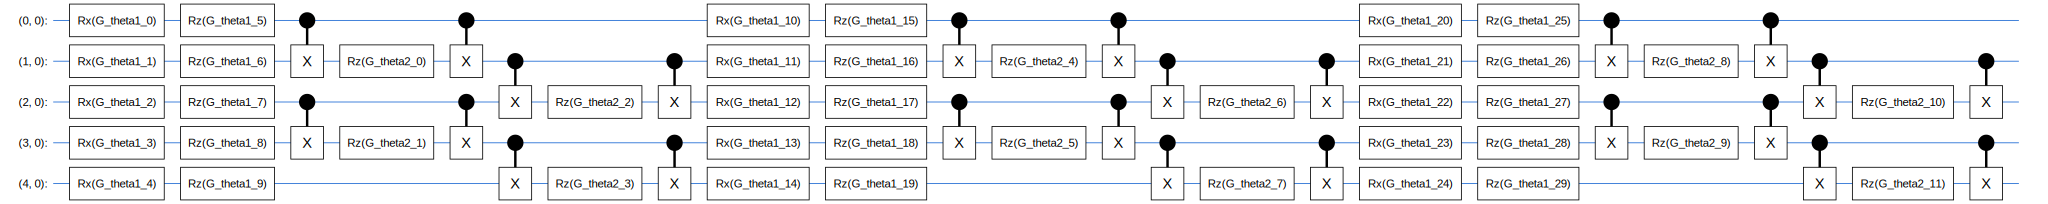

In [ ]:
circ,symbols = generator_pqc_circuit(cirq.GridQubit.rect(5,1),layers=3)
SVGCircuit(circ)
# print(symbols)

In [ ]:
def data_encoding_circuit(qubits):
  circuit = cirq.Circuit()
  input_symbols = sp.symbols('x_:'+str(len(qubits)))
  for i,q in enumerate(qubits):
    circuit += cirq.ry(input_symbols[i])(q)
  return circuit,input_symbols

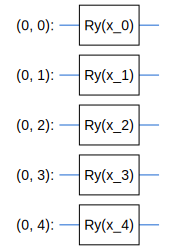

In [ ]:
SVGCircuit(data_encoding_circuit(cirq.GridQubit.rect(1,5))[0])

In [ ]:
# def generator_layer(qubits,use_entanglement=True,layers=1,name = "generator_pqc_"):
#   observables = [cirq.Z(q) for q in qubits]
#   circuit,symbols = generator_pqc_circuit(qubits,layers)
#   g_layer = tfq.layers.ControlledPQC(circuit,observables)
#   thetas_init = tf.random_uniform_initializer(minval=-np.pi/2, maxval=np.pi/2)
#   params = tf.Variable(
#             initial_value=thetas_init(shape=(1, len(symbols)), dtype="float32"),
#             trainable=True, name=name + "thetas")
#   empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])
#   return g_layer([empty_circuit,params])

In [ ]:
class GeneratorPQC(tf.keras.layers.Layer):
  def __init__(self,data_circuit,variational_circuit,n_qubits,use_entanglement=True,name = "GeneratorPQC"):
    super(GeneratorPQC,self).__init__(name=name)
    self.n_qubits=n_qubits
    # self.n_layers=n_layers
    self.use_entanglement=use_entanglement
    self.main_name = name
    # self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])
    # self.qubits = cirq.GridQubit.rect(1, n_qubits)
    # self.observables = [cirq.Z(q) for q in self.qubits]
    self.append_layer = elementary.AddCircuit()
    # circuit,symbols,input_symbols = generator_pqc_circuit(qubits=self.qubits,layers=self.n_layers)
    self.encoding_circuit,self.input_symbols = data_circuit
    self.encoding_circuit = tfq.convert_to_tensor([self.encoding_circuit])
    # data_circuit = QuantumCircuit.from_cirq(data_circuit)
    self.op_circuit,self.param_symbols = variational_circuit
    self.op_circuit = tfq.convert_to_tensor([self.op_circuit])
    # variational_circuit = QuantumCircuit.from_cirq(variational_circuit)
    self.operators = [cirq.Z(q) for q in variational_circuit[0].all_qubits()]
    self.parameters = self.add_weight('parameters',
                                          shape=(1,len(self.param_symbols)),
                                          # initializer=self.initializer,
                                          # regularizer=self.regularizer,
                                          # constraint=self.constraint,
                                          dtype=tf.float32,
                                          trainable=True)
    self.demo_circuit = data_circuit[0] +variational_circuit[0]
    symbols = [str(symb) for symb in self.input_symbols + self.param_symbols]
    self.indices = tf.constant([sorted(symbols).index(a) for a in symbols])
    # thetas_init = tf.random_uniform_initializer(minval=-np.pi/2, maxval=np.pi/2)
    # self.params = tf.Variable(
    #         initial_value=thetas_init(shape=(1, symbols), dtype="float32"),
    #         trainable=True, name=self.main_name + "thetas")
    self.computation_layer = tfq.layers.ControlledPQC(self.demo_circuit,self.operators)
    
  def get_config(self):
    config = super().get_config().copy()
    config.update({
            'n_qubits': self.n_qubits,
            'n_layers': self.n_layers,
            'use_entanglement': self.use_entanglement,
            'name': self.main_name,
    })
    return config
  
  def call(self,inputs):
    batch_size = tf.shape(inputs)[0]
    tiled_encoding_circuit = tf.tile(self.encoding_circuit,[batch_size])
    tiled_variational_circuit = tf.tile(self.op_circuit,[batch_size])
    # full_circuit_batch = self.append_layer(tiled_encoding_circuit,tiled_variational_circuit)
    full_circuit_batch = tfq.layers.AddCircuit()(tiled_encoding_circuit,append=tiled_variational_circuit)
    # empty_circuit_batch = tf.repeat(self.empty_circuit, repeats=batch_size, name=self.main_name + '-tiled_up_empty_circuits') 
    tiled_parameters = tf.tile(self.parameters, multiples=[batch_size,1], name=self.main_name + '-tiled_up_empty_thetas') 
    joined_params = tf.concat([inputs,tiled_parameters],axis=-1)
    
    # joined_params = tf.gather(joined_params,self.indices,axis=-1,name=self.main_name + '-joined_parameters')
    # tiled_operators = tf.tile(self.operators,[batch_size,1])
    # return self.computation_layer([empty_circuit_batch,self.parameters])
    return self.computation_layer([full_circuit_batch,joined_params])

In [ ]:
n_gen_qubits = len(X_train_0[0])
qubits = cirq.GridQubit.rect(n_gen_qubits,1)
layers = 3
observables = [cirq.Z(q) for q in qubits]
inputs = tf.keras.Input(shape=(n_gen_qubits,))      #,dtype = tf.dtypes.float32
gen_pqc = GeneratorPQC(data_circuit=data_encoding_circuit(cirq.GridQubit.rect(n_gen_qubits,1)),variational_circuit=generator_pqc_circuit(cirq.GridQubit.rect(n_gen_qubits,1),layers=layers),n_qubits=n_gen_qubits)
gen_pqc_layer = gen_pqc(inputs)
# g_layers = tfq.layers.ControlledPQC(generator_pqc_circuit(qubits,layers),observables)(inputs)
generator_model = tf.keras.Model(inputs=[inputs],outputs=[gen_pqc_layer])

In [ ]:
generator_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 GeneratorPQC (GeneratorPQC)  (None, 5)                42        
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


# Dataset

In [ ]:
def prepare_dataset(data,batch_size,seed=None,drop_remainder=True,buffer_size=100):
  buffer_size =len(data[0])
  ds = tf.data.Dataset.from_tensor_slices(data)
  ds = ds.shuffle(buffer_size=buffer_size,seed=seed,reshuffle_each_iteration=True)
  ds = ds.batch(batch_size,drop_remainder)
  # ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
def train_preprocess(random_state):
  tf.random.set_seed(random_state)
  np.random.seed(random_state)

# Loss

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

@tf.function
def generator_loss(fake_output):
  return loss(tf.ones_like(fake_output),fake_output)

@tf.function
def discriminator_loss(real_output,fake_output):
  real_loss = loss(tf.ones_like(real_output),real_output)
  fake_loss = loss(tf.ones_like(fake_output),fake_output)
  return real_loss + fake_loss

In [ ]:
# batch_size = 50
# z_shape = (batch_size,) 
# print( generator_model.input_shape[1:])
discriminator_optimizer = tf.keras.optimizers.get('adam')
generator_optimizer = tf.keras.optimizers.get('adam')

# Gradient descent

In [ ]:
from tensorflow.python.eager.backprop import GradientTape
@tf.function
def discriminator_step(x_real,batch_size):
  fake_data_shape = (batch_size,) + generator_model.input_shape[1:]
  x_real = tf.reshape(x_real,fake_data_shape)
  z = tf.random.normal(shape=fake_data_shape)
  with tf.GradientTape() as gradient_tape:
    real_output = discriminator_model(x_real,training = True)
    fake_input = generator_model(z, training = True)
    # fake_input = tf.reshape(fake_input, tf.shape(x_real))
    fake_output = discriminator_model(fake_input,training = True)
    cost = discriminator_loss(real_output,fake_output)
  grad = gradient_tape.gradient(cost,discriminator_model.trainable_variables)
  discriminator_optimizer.apply_gradients(zip(grad,discriminator_model.trainable_variables))
  return cost

In [ ]:
@tf.function
def generator_step(batch_size):
  fake_data_shape = (batch_size,) + generator_model.input_shape[1:]
  z = tf.random.normal(shape=fake_data_shape)
  with tf.GradientTape() as gradient_tape:
    fake_input = generator_model(z,training=True)
    fake_output = discriminator_model(fake_input,training= True) 
    loss = generator_loss(fake_output)
  grad = gradient_tape.gradient(loss,generator_model.trainable_variables)
  generator_optimizer.apply_gradients(zip(grad,generator_model.trainable_variables))
  return loss

In [ ]:
@tf.function
def train_step_1v1(x_real,batch_size):
  
  """Training step for one epoch with 1 generator step and 1 discriminator step
        """
  fake_data_shape = (batch_size,) + generator_model.input_shape[1:]
  z = tf.random.normal(shape=fake_data_shape)
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    x_fake_ = generator_model(z, training=True)
    # x_fake = tf.reshape(x_fake_, tf.shape(x_real))
    real_output = discriminator_model(x_real, training=True)
    fake_output = discriminator_model(x_fake_, training=True)
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
  grad_gen = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
  grad_disc = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)
  generator_optimizer.apply_gradients(zip(grad_gen, generator_model.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(grad_disc, discriminator_model.trainable_variables))  
  return gen_loss, disc_loss

In [ ]:
@tf.function
def train_step_nv1(x_real,n_disc,batch_size):
  for i in range(n_disc):
    x_real_batch = tf.gather(x_real,i)
    d_loss = discriminator_step(x_real_batch,batch_size)
  g_loss = generator_step(batch_size)
  return g_loss, d_loss

In [ ]:
@tf.function
def train_step_1vn(x_real,n_gen,batch_size):
  for i in range(n_gen):
    g_loss = generator_step(batch_size)
  d_loss = discriminator_step(x_real,batch_size)
  return g_loss, d_loss 

In [ ]:
gen_loss_ = []
disc_loss_ = []
epochs_ = []

In [ ]:
# Define one training step
# train_step = train_step_nv1

In [ ]:
def train_qgans(x,epochs,batch_size,seed=1024,n_disc=1,n_gen=1):
  input_shape = x.shape[1:]
  train_preprocess(seed)
  data = prepare_dataset(data=x,batch_size=batch_size*n_disc,seed=seed)
  g_metric = tf.keras.metrics.Mean()
  d_metric = tf.keras.metrics.Mean()
  for epoch in range(epochs):
    for step,training_batch_data_ in enumerate(data):
      # training_batch_data = tf.reshape(training_batch_data_,input_batch_shape)
      if( n_disc == 1 and n_gen == 1):
        input_batch_shape = (batch_size,) + input_shape
        training_batch_data = tf.reshape(training_batch_data_,input_batch_shape)
        gen_loss,disc_loss = train_step_1v1(x_real=training_batch_data, batch_size=batch_size)
      if n_disc > 1 and n_gen == 1:
        input_batch_shape = (n_disc, batch_size) + input_shape
        training_batch_data = tf.reshape(training_batch_data_,input_batch_shape)        
        gen_loss,disc_loss = train_step_nv1(x_real=training_batch_data, batch_size=batch_size,n_disc=n_disc)
      if n_gen > 1 and n_disc == 1:
        input_batch_shape = (batch_size,) + input_shape
        training_batch_data = tf.reshape(training_batch_data_,input_batch_shape)
        gen_loss,disc_loss = train_step_1vn(x_real=training_batch_data, batch_size=batch_size,n_gen=n_gen)
      g_metric(gen_loss)
      d_metric(disc_loss)
    gen_loss_.append(g_metric.result().numpy())
    disc_loss_.append(d_metric.result().numpy())
    epochs_.append(epoch)
    print("Epoch:{} ;   generator_loss:{} ;   discriminator_loss:{}".format(epoch,g_metric.result().numpy(),d_metric.result().numpy()))
  
    g_metric.reset_state()
    d_metric.reset_state()
  # samples = generate_samples(batch_size=50).numpy()
  # make_plots([X_train_1, samples], ['true signal', 'fake signal']) 

In [ ]:
train_qgans(X_train_1,epochs=300,batch_size=5,n_disc=5)

Epoch:0 ;   generator_loss:0.6270591616630554 ;   discriminator_loss:1.497978925704956
Epoch:1 ;   generator_loss:0.5630720257759094 ;   discriminator_loss:1.4342615604400635
Epoch:2 ;   generator_loss:0.638034999370575 ;   discriminator_loss:1.5363991260528564
Epoch:3 ;   generator_loss:0.5147250890731812 ;   discriminator_loss:1.1918480396270752
Epoch:4 ;   generator_loss:0.4784556031227112 ;   discriminator_loss:1.2564575672149658
Epoch:5 ;   generator_loss:0.47855451703071594 ;   discriminator_loss:1.242349624633789
Epoch:6 ;   generator_loss:0.4446598291397095 ;   discriminator_loss:1.1487302780151367
Epoch:7 ;   generator_loss:0.44349583983421326 ;   discriminator_loss:1.0289134979248047
Epoch:8 ;   generator_loss:0.4567307233810425 ;   discriminator_loss:1.0567556619644165
Epoch:9 ;   generator_loss:0.47690749168395996 ;   discriminator_loss:1.0714387893676758
Epoch:10 ;   generator_loss:0.38312506675720215 ;   discriminator_loss:0.9477353692054749
Epoch:11 ;   generator_loss:0.

In [ ]:
print(gen_loss_)
print(disc_loss_)
print(min(gen_loss_))
print(min(disc_loss_))

[0.62705916, 0.563072, 0.638035, 0.5147251, 0.4784556, 0.47855452, 0.44465983, 0.44349584, 0.45673072, 0.4769075, 0.38312507, 0.43745053, 0.4210269, 0.4158386, 0.421229, 0.36799765, 0.37545788, 0.40393662, 0.35404915, 0.38199425, 0.36807916, 0.36504304, 0.356867, 0.38200593, 0.3544447, 0.3700388, 0.3468753, 0.36610356, 0.34912056, 0.36250186, 0.3558336, 0.3605015, 0.33708638, 0.3567078, 0.32721537, 0.34332386, 0.34315965, 0.3456002, 0.34219152, 0.34350896, 0.3405385, 0.33151668, 0.3366733, 0.3420524, 0.3311742, 0.34939158, 0.3381641, 0.3336736, 0.3462497, 0.33507645, 0.33806488, 0.32907355, 0.33971858, 0.32962847, 0.34085584, 0.32506448, 0.3351404, 0.32872736, 0.33217084, 0.32827163, 0.3325249, 0.33557183, 0.32619333, 0.33263665, 0.33046824, 0.33143795, 0.32988507, 0.32410258, 0.33101135, 0.32377654, 0.3343493, 0.3288378, 0.32783473, 0.32862294, 0.32357532, 0.3227889, 0.31911317, 0.32458645, 0.32694316, 0.32527703, 0.32599723, 0.32131624, 0.32118192, 0.32364362, 0.32070953, 0.32434505,

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_loss(gen_loss,disc_loss,epochs):
  fig = plt.figure(figsize=(16,9))
  gs = gridspec.GridSpec(ncols=8, nrows=8, figure=fig)
  epoch = epochs[-1]
  # plot loss curve
  ax_loss = plt.subplot(gs[:,:4])
  ax_loss.set_xlim(0, 1.1*epoch)
  ax_loss.plot(epochs, gen_loss, label="Generator")
  ax_loss.plot(epochs, disc_loss, label="Discriminator")
  ax_loss.set_xlabel('Epoch', fontsize=20)
  ax_loss.set_ylabel('Loss', fontsize=20)
  ax_loss.grid(True)
  ax_loss.legend(fontsize=15)


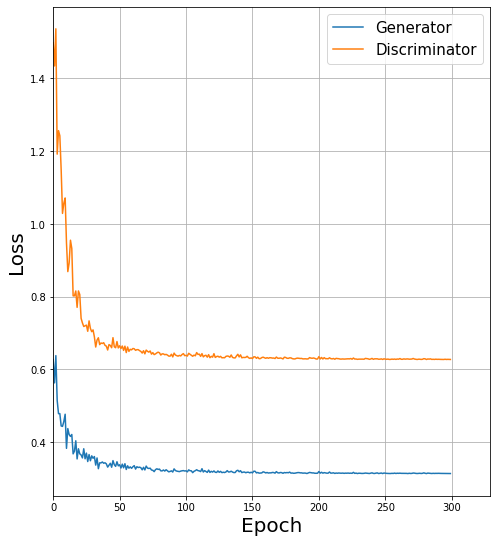

In [ ]:
plot_loss(gen_loss_,disc_loss_,epochs_)

In [ ]:
input_batch_shape = (5, 20) + (5,)
data = prepare_dataset(X_train_1,batch_size=20,seed=1024)
# print(tf.shape(data))
# data = tf.reshape(data,input_batch_shape)
print(input_batch_shape)

(5, 20, 5)


In [ ]:
# print(X_train_1.shape[1:])
# print()

In [ ]:
# batch_size = 50
# z_batch_shape = (batch_size,) + generator_model.input_shape[1:]
# z_batch_shape = generator_model.input_shape[1:]
# z = tf.random.normal(z_batch_shape)
# print(z.numpy())

In [ ]:
def generate_samples( batch_size, shape=None):

  """Generates sample using random inputs
        
            Arguments:
                batch_size: int
                    Number of samples to generate.
                shape: (Optional) tuple of int
                    Reshape the output to the given shape.
        """
  z_batch_shape = (batch_size,) + generator_model.input_shape[1:]
  z = tf.random.normal(z_batch_shape)
  print(z.shape[0])
  samples = generator_model(z,training = False)
  # samples = generator_model
  # if shape is not None:
  #   shape = (batch_size,) + shape
  #   samples = tf.reshape(samples, shape)
  return samples

# generate_samples(batch_size=10)

50


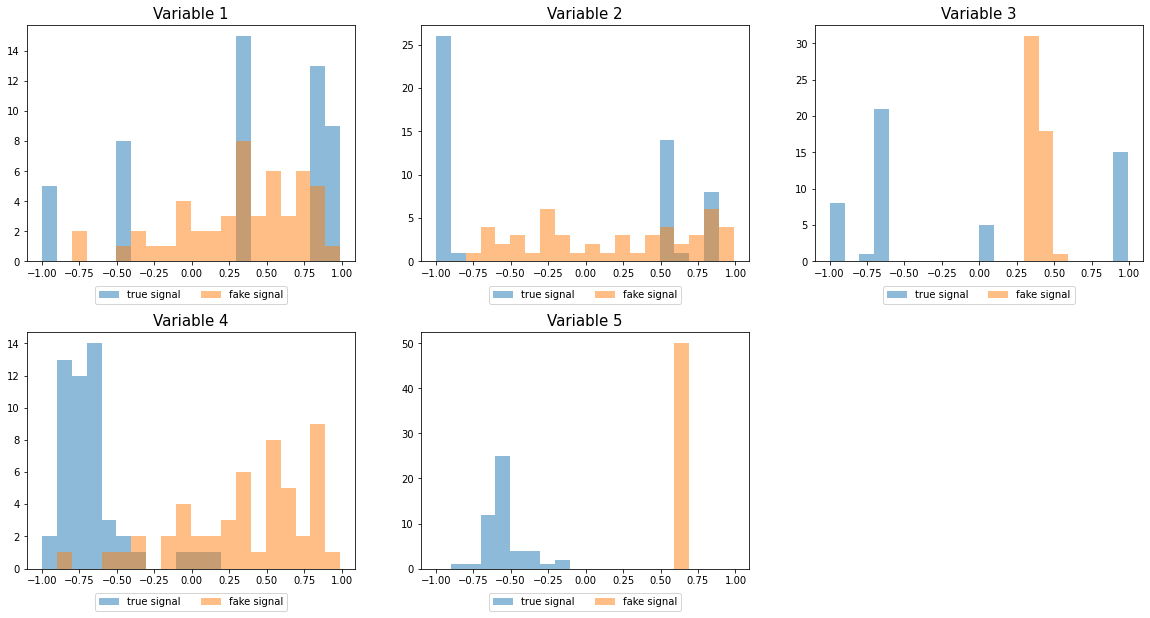

(50, 5)


In [ ]:
# samples = generate_samples(batch_size=50,shape=(5,)).numpy()
samples = np.array(generate_samples(batch_size=50,shape=(5,)))
make_plots([X_train_1, samples], ['true signal', 'fake signal'])
# print(type(samples))
print(samples.shape)

In [ ]:
def predict_gans(x):
  return discriminator_model(x,training=False)

# predict_gans(X_train_0[40:,])

In [ ]:
def plot_roc_curve(fpr_list,tpr_list,name='QGANS',title='ROC Curve', with_auc=True,labels=''):
  n = len(fpr_list)
  if labels =='':
    labels = ['']*n

  plt.clf()
  plt.rcParams["font.weight"] = "bold"
  plt.xlabel("Signal Efficiency", fontsize=18,fontweight='bold')
  plt.ylabel("Background Rejection", fontsize=18,fontweight='bold')
  plt.title(title, fontsize=16,fontweight='bold')
  plt.xlim(0.0, 1.0)
  plt.ylim(0.0, 1.0)
  plt.grid(color='gray', linestyle='--', linewidth=1)  
  for fpr,tpr,label in zip(fpr_list, tpr_list, labels):
    if with_auc:
      roc_auc = auc(fpr, tpr)
      label += ', AUC={:.4f}'.format(roc_auc)
    plt.plot(tpr,1-fpr, linestyle='-',label=label,linewidth=2)
  plt.plot([0, 1], [1, 0], linestyle='--', color='black', label=' AUC= 0.5')
  plt.legend(loc='best',prop={'size': 8})    
  return plt  


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
def test_gans( x, y, plot=True):
  score = predict_gans(x)
  fpr, tpr, thresholds = roc_curve(y, score)
  roc_auc = auc(fpr, tpr)
  print("AUC = ",roc_auc)
  if plot:
    return plot_roc_curve(fpr_list=[fpr],tpr_list=[tpr], name='QGAN_with_DataReuploading')
  else:
    return roc_auc

AUC =  0.5984


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

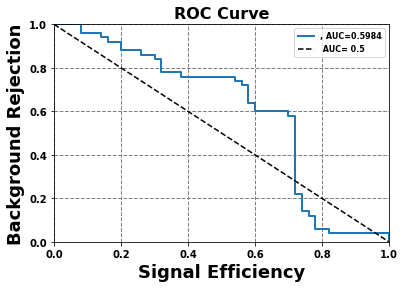

In [ ]:
test_gans(X_test,y_test)

In [ ]:
# H = discriminator_model.trainable_variables
# H_ = discriminator_model.weights

# print(H)
# print(H_)